In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# CONFIGURACIÓN
LEAGUES_BIG5 = [
    'ENG-Premier League',
    'ESP-La Liga',
    'ITA-Serie A',
    'GER-Bundesliga',
    'FRA-Ligue 1'
]
SEASON = '2526'
MIN_MINUTES = 0  # Sin restricción de minutos

os.makedirs('figures', exist_ok=True)

In [3]:
# Funciones auxiliares
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    if value is None or pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.strip() == '' or value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    return np.nan

def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%',
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

In [4]:
# Leer eventos completos y filtrar shots
print("Generando CSV de shots desde eventos...")
df_events = pd.read_csv('../data/ansu_fati_all_events_25-26.csv')

# Filtrar solo eventos que son shots (is_shot == True)
df_shots = df_events[df_events['is_shot'] == True].copy()

# Renombrar columna para compatibilidad con viz.shot_xg
df_shots = df_shots.rename(columns={'shot_body_part': 'body_part'})

# Verificar columnas necesarias
required_cols = ['x', 'y', 'xg', 'type', 'player', 'team', 'outcome_type', 'match_date', 'opponent', 'venue']
missing_cols = [col for col in required_cols if col not in df_shots.columns]
if missing_cols:
    print(f"ADVERTENCIA: Columnas faltantes: {missing_cols}")

# Guardar CSV de shots
shots_path = '../data/ansu_fati_all_shots_25-26.csv'
df_shots.to_csv(shots_path, index=False)

print(f"✓ Guardado: {shots_path}")
print(f"  Total shots: {len(df_shots)}")
print(f"  Goals: {df_shots['is_goal'].sum() if 'is_goal' in df_shots.columns else df_shots[df_shots['type'] == 'Goal'].shape[0]}")
print(f"\nDistribución por tipo:")
print(df_shots['type'].value_counts())

Generando CSV de shots desde eventos...
✓ Guardado: ../data/ansu_fati_all_shots_25-26.csv
  Total shots: 7
  Goals: 5

Distribución por tipo:
type
Goal           5
MissedShots    2
Name: count, dtype: int64


In [5]:
from viz.shot_xg import plot_shot_xg
import pandas as pd

print("Cargando datos de Ansu Fati...")
df_shots = pd.read_csv('../data/ansu_fati_all_shots_25-26.csv')

# Shot map 1: COMPLETO
print("\n1. Generando shot map completo...")
fig = plot_shot_xg(
    csv_path='../data/ansu_fati_all_shots_25-26.csv',
    filter_by='Ansu|Fati',
    logo_path='../caras/extras/AnsuFati.png',
    title_text='Ansu Fati',
    subtitle_text='Expected Goals',
    subsubtitle_text='AS Monaco | 2025-26'
)
if fig:
    fig.savefig('figures/ansu_fati_shotmap_25-26.png', dpi=300, bbox_inches='tight', facecolor='#313332')
    plt.close()
    print("✓ Shot map completo guardado")
else:
    print("✗ Error generando shot map completo")

# Shot map 2: SOLO GOLES
print("\n2. Generando shot map solo goles...")
df_goals = df_shots[df_shots['type'] == 'Goal']
temp_goals_path = '../data/temp_ansu_goals.csv'
df_goals.to_csv(temp_goals_path, index=False)

fig_goals = plot_shot_xg(
    csv_path=temp_goals_path,
    filter_by='Ansu|Fati',
    logo_path='../caras/extras/AnsuFati.png',
    title_text='Ansu Fati',
    subtitle_text='Goals Only',
    subsubtitle_text='AS Monaco | 2025-26'
)
if fig_goals:
    fig_goals.savefig('figures/ansu_fati_shotmap_goals_25-26.png', dpi=300, bbox_inches='tight', facecolor='#313332')
    plt.close()
    print("✓ Shot map goles guardado")
else:
    print("✗ Error generando shot map goles")

# Shot map 3: SIN GOLES
print("\n3. Generando shot map sin goles...")
df_no_goals = df_shots[df_shots['type'] != 'Goal']
temp_no_goals_path = '../data/temp_ansu_no_goals.csv'
df_no_goals.to_csv(temp_no_goals_path, index=False)

fig_no_goals = plot_shot_xg(
    csv_path=temp_no_goals_path,
    filter_by='Ansu|Fati',
    logo_path='../caras/extras/AnsuFati.png',
    title_text='Ansu Fati',
    subtitle_text='Non-Goals',
    subsubtitle_text='AS Monaco | 2025-26'
)
if fig_no_goals:
    fig_no_goals.savefig('figures/ansu_fati_shotmap_no_goals_25-26.png', dpi=300, bbox_inches='tight', facecolor='#313332')
    plt.close()
    print("✓ Shot map sin goles guardado")
else:
    print("✗ Error generando shot map sin goles")

# Limpiar archivos temporales
import os
if os.path.exists(temp_goals_path):
    os.remove(temp_goals_path)
if os.path.exists(temp_no_goals_path):
    os.remove(temp_no_goals_path)

print("\n✓ 3 shot maps completados")

Cargando datos de Ansu Fati...

1. Generando shot map completo...
✓ Shot map completo guardado

2. Generando shot map solo goles...
✓ Shot map goles guardado

3. Generando shot map sin goles...
✓ Shot map sin goles guardado

✓ 3 shot maps completados


In [6]:
db = get_db_manager()

league_list_str = "', '".join(LEAGUES_BIG5)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY league, team, player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros (Big5 sin filtro minutos)")
df_raw.head()

2025-10-12 20:49:14,513 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-10-12 20:49:15,118 - database.connection - INFO - Database connection successful


Extraídos: 2165 registros (Big5 sin filtro minutos)


,unique_player_id,player_name,team,league,season,position,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2526,DF,"{'FK': '0', 'G-xG': '0.0', 'A-xAG': '0.0', 'Cr...","{'understat_xa': '0.060895293951034546', 'unde..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2526,FW,"{'FK': '0', 'G-xG': '0.8', 'A-xAG': '-0.8', 'C...","{'understat_xa': '1.1351527459919453', 'unders..."
2,e94c51c954d24b45,Cristhian Mosquera,Arsenal,ENG-Premier League,2526,DF,"{'FK': '0', 'G-xG': '0.0', 'A-xAG': '0.0', 'Cr...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
3,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2526,GK,"{'FK': '0', 'G-xG': '0.0', 'A-xAG': '-0.1', 'C...","{'understat_xa': '0.049500007182359695', 'unde..."
4,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2526,MF,"{'FK': '2', 'G-xG': '0.5', 'A-xAG': '0.8', 'Cr...","{'understat_xa': '1.1279222760349512', 'unders..."


In [7]:
# PASO 1: Sin filtrar por minutos (MIN_MINUTES = 0)
if MIN_MINUTES > 0:
    df_filtered = df_raw[
        df_raw['fbref_metrics'].apply(
            lambda x: x.get('minutes_played', 0) if x else 0
        ) >= MIN_MINUTES
    ].copy()
    print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
else:
    df_filtered = df_raw.copy()
    print(f"Sin filtro de minutos: {df_filtered.shape[0]} jugadores")

# PASO 2: Filtrar por posición FW
df_filtered = df_filtered[df_filtered['position'].str.contains('FW', na=False)].copy()
print(f"Filtro FW: {df_filtered.shape[0]} delanteros")

# PASO 3: Extraer métricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} | Understat: {understat_nums.shape[1]}")

Sin filtro de minutos: 2165 jugadores
Filtro FW: 708 delanteros
FBref: 185 | Understat: 10


In [8]:
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

# Combinar métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)
print(f"Métricas totales: {all_metrics.shape[1]}")

Métricas totales: 356


In [9]:
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]
print(f"Percentiles: {all_percentiles.shape[1]}")

Percentiles: 356


In [10]:
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

df_final = clean_series_values(df_final)
df_final = df_final.drop(columns=[col for col in ['shots_on_target_pct'] if col in df_final.columns])

print(f"✓ DataFrame final: {df_final.shape[0]} FW, {df_final.shape[1]} columnas")
df_final.head()

Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
✓ DataFrame final: 708 FW, 716 columnas


,unique_player_id,player_name,team,league,season,position,Penalty Kicks_PKsv,total_pass_distance,tackles_won,Aerial Duels_Won%,...,Pass Types_Dead_per90_pct,key_passes_per90_pct,Outcomes_Cmp_per90_pct,understat_np_xg_per90_pct,understat_xg_chain_per90_pct,understat_xg_buildup_per90_pct,understat_xa_per90_pct,understat_np_goals_per90_pct,understat_npxg_plus_xa_per90_pct,understat_key_passes_per90_pct
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2526,FW,NaN,1694.0,NaN,NaN,...,81,78,68,42,75,89,85,68,54,78
5,22123e3be762495a,Eberechi Eze,Arsenal,ENG-Premier League,2526,"MF,FW",NaN,1619.0,NaN,NaN,...,59,44,76,60,79,78,88,31,71,55
8,deb1a78ccb27dcbb,Gabriel Martinelli,Arsenal,ENG-Premier League,2526,FW,NaN,346.0,NaN,NaN,...,54,48,11,33,12,8,39,82,9,49
10,4760df351722a988,Kai Havertz,Arsenal,ENG-Premier League,2526,FW,NaN,79.0,NaN,NaN,...,13,12,31,7,59,90,12,31,<NA>,12
11,3a74cbef8959ca46,Leandro Trossard,Arsenal,ENG-Premier League,2526,FW,NaN,1734.0,NaN,NaN,...,27,69,71,51,49,68,52,31,36,69


In [11]:
TEAM_COLORS_PALETTE = [
    '#FF6B6B',      # Coral Red
    '#4ECDC4',      # Turquoise
    '#FFFFFF',      # White
    '#000000',      # Black
    '#00BFFF',      # Deep Sky Blue
    '#00FFFF',      # Cyan
    '#7CFC00',      # Lawn Green
    '#FFFF00',      # Yellow
    '#FFD700',      # Gold
    '#FFB6C1',      # Light Pink
    '#FF6347',      # Tomato
    '#FF4500',      # Orange Red
    '#32CD32',      # Lime Green
    '#DA70D6',      # Orchid
    '#004D98',      # Navy Blue
    '#8B0000',      # Dark Red
    '#800080',      # Purple
    '#FF8C00',      # Dark Orange
    '#20B2AA',      # Light Sea Green
    '#DC143C',      # Crimson
    '#A50044',      # Barcelona Grana
    '#0066CC',      # Barcelona Azul
    '#722F37',      # West Ham Granate
    '#87CEEB',      # Sky Blue
    '#6A5ACD',      # Slate Blue
    '#FF1493',      # Deep Pink
    '#00FF7F',      # Spring Green
    '#FFE4B5',      # Moccasin
    '#B22222',      # Fire Brick
    '#48D1CC',      # Medium Turquoise
    '#FFA500',      # Orange
    '#9370DB',      # Medium Purple
    '#F0E68C',      # Khaki
    '#FF69B4',      # Hot Pink
    '#00CED1'       # Dark Turquoise
]

players_search = [
    {'name': 'Ansu|Fati', 'team': 'Monaco', 'cara': '../caras/extras/AnsuFati.png'},
    # {'name': 'Haaland', 'team': 'Man City', 'cara': '../caras/extras/Haaland.png'},
    # {'name': 'Lewandowski', 'team': 'Barcelona', 'cara': '../caras/extras/Lewandoski.png'},
    # {'name': 'Rashford', 'team': 'Man Utd', 'cara': '../caras/extras/Rashford.png'},
    # {'name': 'Leão', 'team': 'Milan', 'cara': '../caras/extras/Leao.png'}
]

player_data = {}

for p in players_search:
    matches = df_final[
        df_final['player_name'].str.contains(p['name'], case=False, na=False, regex=True)
    ]
    
    if len(matches) > 0:
        player_row = matches.iloc[0]
        player_data[p['name']] = {
            'id': player_row['unique_player_id'],
            'full_name': player_row['player_name'],
            'team': player_row['team'],
            'league': player_row['league'],
            'cara': p['cara']
        }
        print(f"✓ {p['name']:12} → {player_row['player_name']:25} ({player_row['team']})")
    else:
        print(f"✗ {p['name']:12} → NO ENCONTRADO")

print(f"\n✓ Total: {len(player_data)}/{len(players_search)} jugadores")

✓ Ansu|Fati    → Ansu Fati                 (Monaco)

✓ Total: 1/1 jugadores


In [12]:
fw_metrics = [
    'expected_goals_per90', 'goals_per90', 'shots_per90', 'Touches_Att Pen_per90',
    'expected_assists_per90', 'Take-Ons_Succ_per90', 'npxG/Sh', 'G-xG_per90',
    'Fld_per90', 'SCA_SCA90'
]
fw_titles = [
    'Expected Goals', 'Goals', 'Shots', 'Touches in Box',
    'Expected Assists', 'Dribbles', 'npxG per Shot', 'Goals - xG',
    'Fouls Drawn', 'Shot Creating Actions'
]

print(f"Métricas FW: {len(fw_metrics)} | Títulos: {len(fw_titles)}")

Métricas FW: 10 | Títulos: 10


Generando radar individual Ansu Fati completo...
✓ Radar individual completo guardado


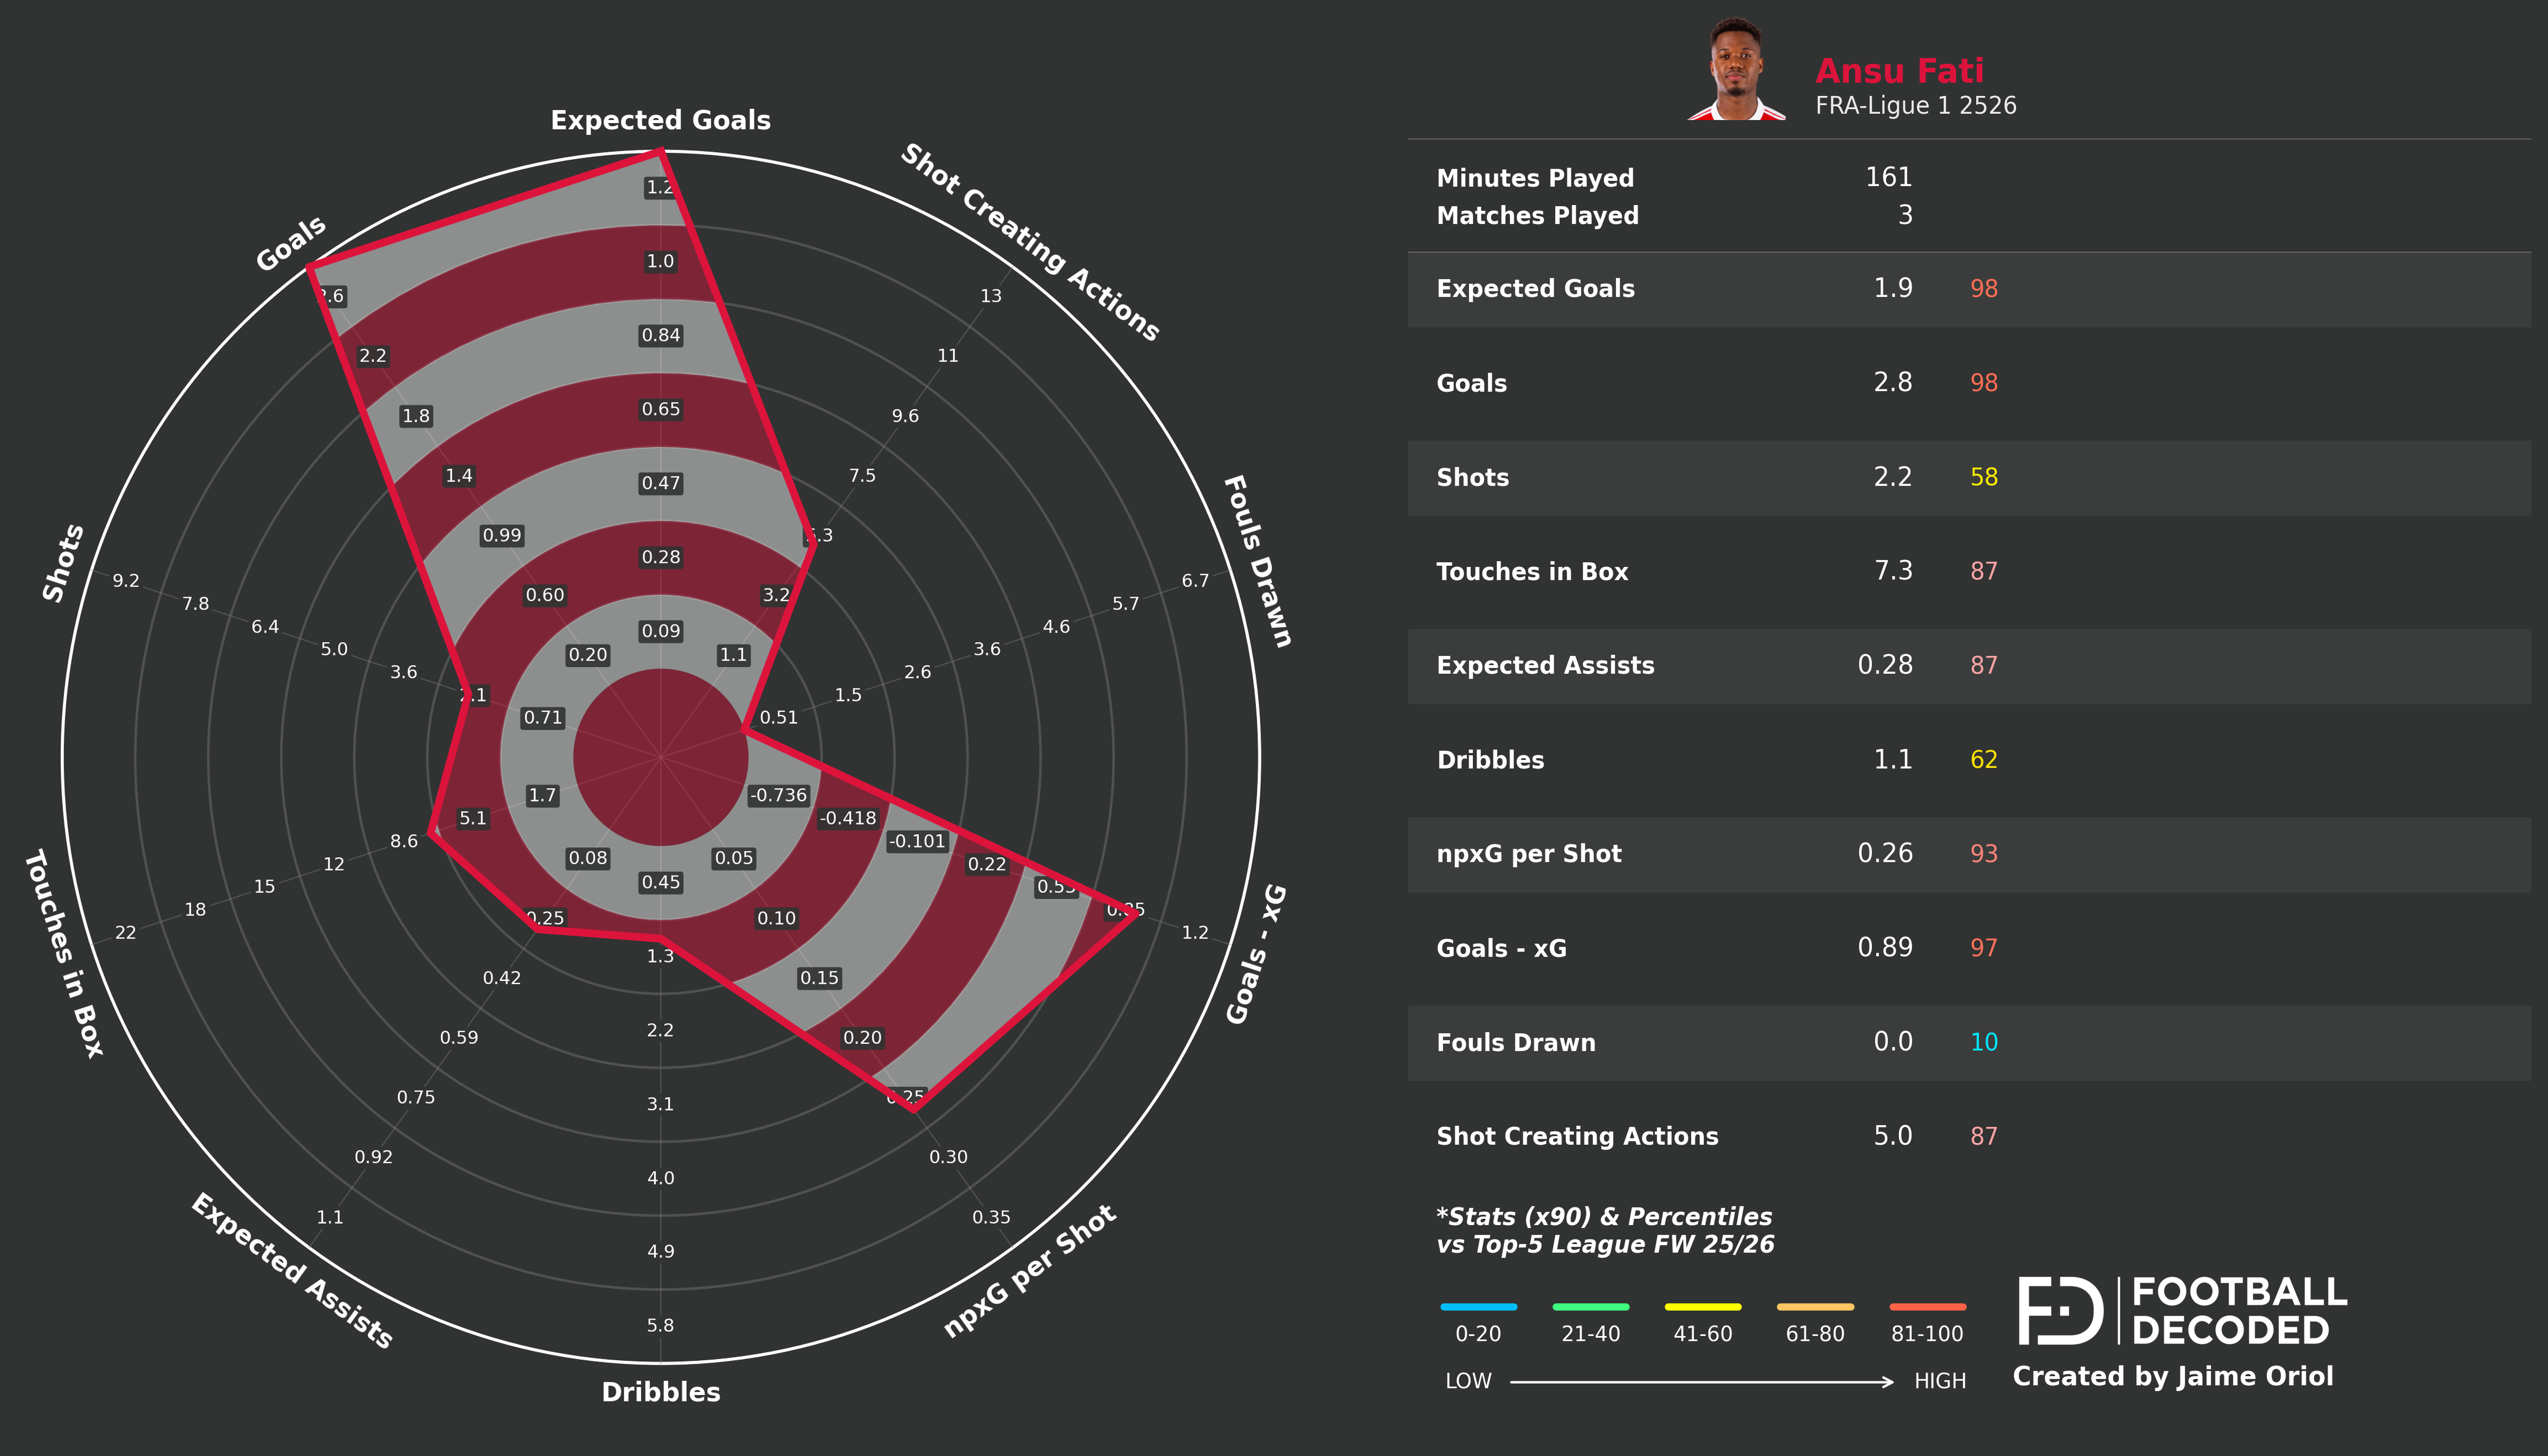

In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

if 'Ansu|Fati' in player_data:
    ansu_id = player_data['Ansu|Fati']['id']
    
    print("Generando radar individual Ansu Fati completo...")
    
    # Radar traditional (sin swarm)
    create_player_radar(
        df_data=df_final,
        player_1_id=ansu_id,
        player_2_id=None,
        metrics=fw_metrics,
        metric_titles=fw_titles,
        team_colors=['#DC143C', '#FFFFFF'],
        save_path='figures/ansu_fati_radar_individual.png',
        use_swarm=False,
        show_plot=False
    )
    
    # Tabla individual con cara
    create_stats_table(
        df_data=df_final,
        player_1_id=ansu_id,
        player_2_id=None,
        metrics=fw_metrics,
        metric_titles=fw_titles,
        team_colors=['#DC143C'],
        save_path='figures/ansu_fati_table_individual.png',
        team_logos={player_data['Ansu|Fati']['team']: player_data['Ansu|Fati']['cara']},
        footer_text="Stats (x90) & Percentiles\nvs Top-5 League FW 25/26",
        show_plot=False
    )
    
    # Combinar
    combine_radar_and_table(
        radar_path='figures/ansu_fati_radar_individual.png',
        table_path='figures/ansu_fati_table_individual.png',
        output_path='figures/ansu_fati_individual_COMBINED.png'
    )
    
    print("✓ Radar individual completo guardado")
    display(IPImage('figures/ansu_fati_individual_COMBINED.png'))
else:
    print("✗ Ansu Fati no encontrado")

In [14]:
# from viz.stats_radar import create_stats_table, combine_radar_and_table

# comparisons = [
#     ('Haaland', '#87CEEB'),
#     ('Lewandowski', '#0066CC'),
#     ('Rashford', '#DC143C'),
#     ('Leão', '#000000')
# ]

# if 'Ansu|Fati' in player_data:
#     ansu_id = player_data['Ansu|Fati']['id']
    
#     for opponent, color in comparisons:
#         if opponent in player_data:
#             opponent_id = player_data[opponent]['id']
            
#             print(f"\nGenerando: Ansu Fati vs {opponent}...")
            
#             # Radar
#             create_player_radar(
#                 df_data=df_final,
#                 player_1_id=ansu_id,
#                 player_2_id=opponent_id,
#                 metrics=fw_metrics,
#                 metric_titles=fw_titles,
#                 team_colors=['#DC143C', color],
#                 save_path=f'figures/ansu_fati_vs_{opponent.lower()}_radar.png',
#                 use_swarm=False,
#                 show_plot=False
#             )
            
#             # Tabla
#             create_stats_table(
#                 df_data=df_final,
#                 player_1_id=ansu_id,
#                 player_2_id=opponent_id,
#                 metrics=fw_metrics,
#                 metric_titles=fw_titles,
#                 team_colors=['#DC143C', color],
#                 save_path=f'figures/ansu_fati_vs_{opponent.lower()}_table.png',
#                 team_logos={
#                     player_data['Ansu|Fati']['team']: player_data['Ansu|Fati']['cara'],
#                     player_data[opponent]['team']: player_data[opponent]['cara']
#                 },
#                 footer_text="Stats (x90) & Percentiles\nvs Top-5 League FW 25/26",
#                 show_plot=False
#             )
            
#             # Combinar
#             combine_radar_and_table(
#                 radar_path=f'figures/ansu_fati_vs_{opponent.lower()}_radar.png',
#                 table_path=f'figures/ansu_fati_vs_{opponent.lower()}_table.png',
#                 output_path=f'figures/ansu_fati_vs_{opponent.lower()}_COMBINED.png'
#             )
            
#             print(f"✓ Completado")
#             display(IPImage(f'figures/ansu_fati_vs_{opponent.lower()}_COMBINED.png'))
#         else:
#             print(f"✗ {opponent} no encontrado")

# print("\n✓ Todos los radares completados")


Generando scatter xG vs Goals (totales)...
8 [-0.43666476  0.03884853]
9 [0.25445524 0.60541835]


2025-10-12 20:49:39,870 - adjustText - WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


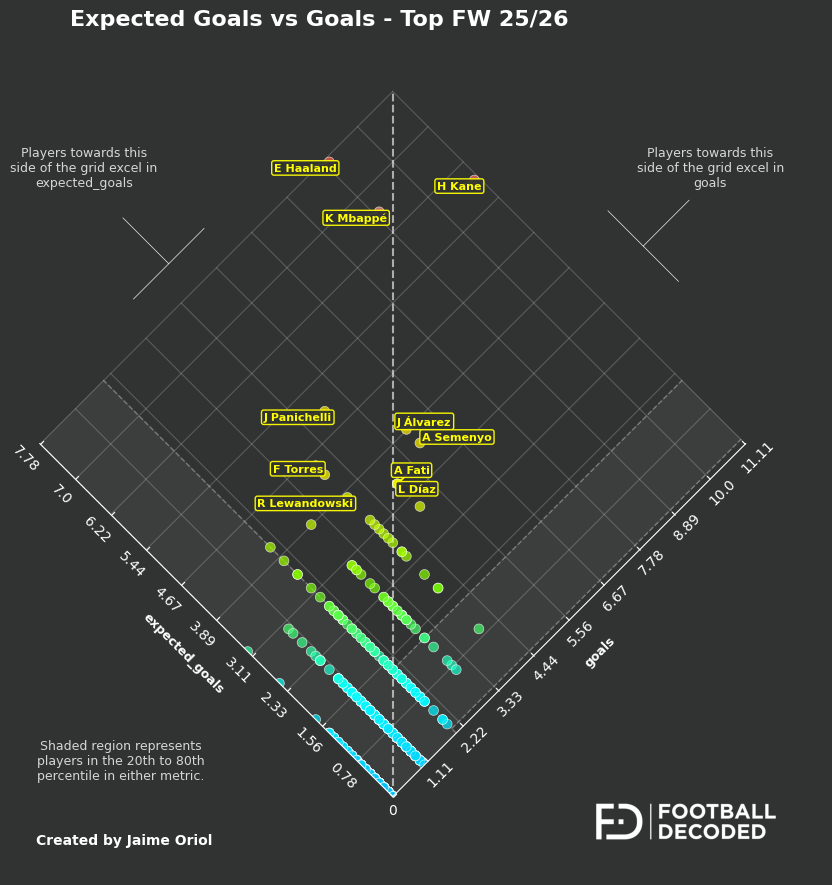

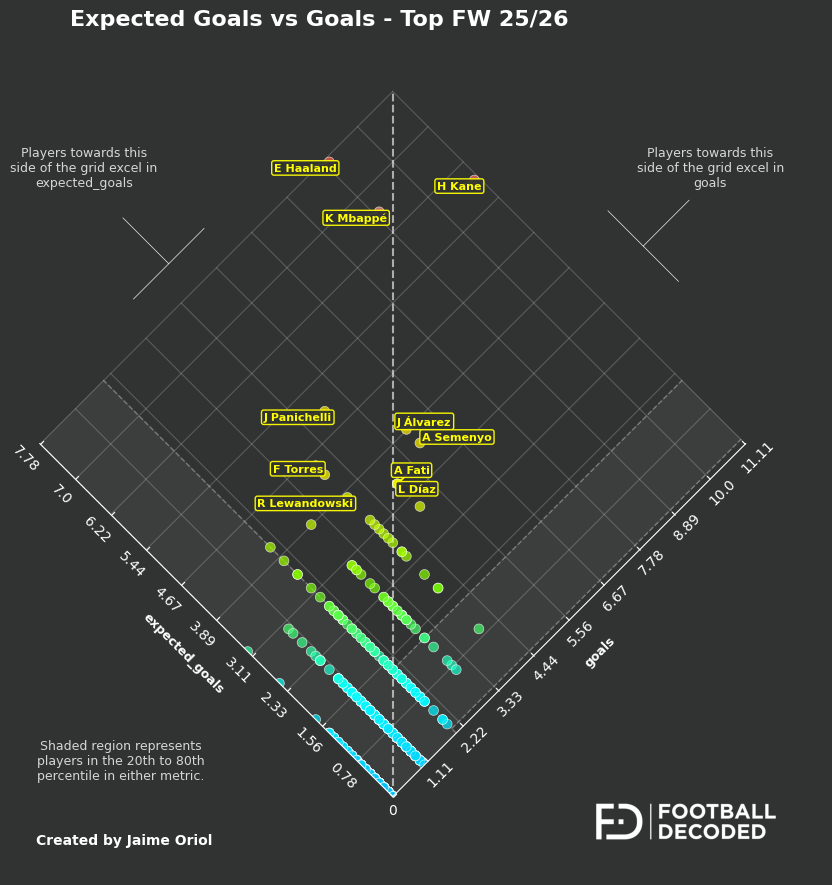

In [15]:
from viz.scatter import create_diamond_scatter

print("\nGenerando scatter xG vs Goals (totales)...")
create_diamond_scatter(
    df=df_final,
    x_metric='expected_goals',
    y_metric='goals',
    title='Expected Goals vs Goals - Top FW 25/26',
    save_filename='scatter_xg_goals_total.png'
)